## Import librabies and read csv

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import re
import nltk
import math
import string
import nltk.stem
from nltk.corpus import stopwords
from collections import Counter

In [ ]:
import pandas as pd
edmunds = pd.read_csv('/content/drive/MyDrive/fyp/edmunds.csv')
edmunds

Car       Overall_rating  \
0         Used 2017 Audi A7     4 out of 5 stars   
1         Used 2017 Audi A7     5 out of 5 stars   
2         Used 2012 Audi A3     5 out of 5 stars   
3         Used 2017 Audi A7     5 out of 5 stars   
4         Used 2012 Audi A3     5 out of 5 stars   
...                     ...                  ...   
12497  Used 2003 Volvo XC70     5 out of 5 stars   
12498  Used 2003 Volvo XC70  4.13 out of 5 stars   
12499  Used 2003 Volvo XC70     4 out of 5 stars   
12500  Used 2003 Volvo XC70  4.75 out of 5 stars   
12501  Used 2003 Volvo XC70  3.25 out of 5 stars   

                                                Title  \
0                                      Slick & Sporty   
1                                          Audiacious   
2                   Second one - Might go for a third   
3                                          Rowdy Audi   
4      Nice dieselGate used car and so comfortable!!!   
...                                               ...   
12497          253,400 miles and still in the passing   
12498                                Just a great car   
12499           Love my XC70, can be expensive though   
12500                    Our '03 XC70 is outstanding!   
12501        Don't leave without extended service con   

                            Owner_Date  \
0           Gregory Demler, 12/18/2019   
1                 Audisome, 08/20/2020   
2         The Amazing Marc, 11/02/2017   
3              Koolgeerapp, 10/06/2021   
4                  Evan F., 04/17/2020   
...                                ...   
12497  Chris from Norwood , 03/22/2009   
12498                  Jim, 07/26/2010   
12499        James Kaufman, 02/20/2015   
12500                 Hugo, 06/01/2005   
12501             bakerman, 03/22/2010   

                                                    Type  \
0      Premium Plus quattro 4dr Sedan AWD (3.0L 6cyl ...   
1      Prestige quattro 4dr Sedan AWD (3.0L 6cyl S/C 8A)   
2      2.0T PZEV Premium 4dr Wagon (2.0L 4cyl Turbo 6AM)   
3      Premium Plus quattro 4dr Sedan AWD (3.0L 6cyl ...   
4           2.0T Premium 4dr Wagon (2.0L 4cyl Turbo 6AM)   
...                                                  ...   
12497                 AWD 4dr Wagon (2.5L 5cyl Turbo 5A)   
12498                 AWD 4dr Wagon (2.5L 5cyl Turbo 5A)   
12499                 AWD 4dr Wagon (2.5L 5cyl Turbo 5A)   
12500                 AWD 4dr Wagon (2.5L 5cyl Turbo 5A)   
12501                 AWD 4dr Wagon (2.5L 5cyl Turbo 5A)   

                                                    Text  
0      This is my 4th Audi.  Unfortunately this vehic...  
1      By far the sexiest car I have ever had!\nSafet...  
2      Its mechanics are identical to a Volkwagen GTI...  
3      All I can say is let's go..it's still worth mo...  
4      I just purchased this after a test drive of ov...  
...                                                  ...  
12497  253,400 miles and still in the passing lane!  ...  
12498  It's just a great comfortable and reliable car...  
12499  My father bought the car in 2007 for about $18...  
12500  We are the second owner at 13,000 miles, bough...  
12501  I bought my used 2003 XC Volvo with thee highe...  

[12502 rows x 6 columns]

In [ ]:
edmunds.isnull().sum()

Car                16
Overall_rating     17
Title              17
Owner_Date         17
Type               24
Text              131
dtype: int64

we can see there're some NULL values, for these review data, we can't really fill in them with median or mean, so we delete them all

In [ ]:
edmunds = edmunds.dropna().reset_index() # index is messed up after dropping the NA, we need to reset it now
edmunds.isnull().sum()

index             0
Car               0
Overall_rating    0
Title             0
Owner_Date        0
Type              0
Text              0
dtype: int64

In [ ]:
len(edmunds)

12362

## Data Preprocessing

Owner and Date are in the same column, here we simply seperate them into two individual columns.

In [ ]:
edmunds['Owner'] = ''
edmunds['Date'] = ''
for x in range(len(edmunds)):
    edmunds['Owner'][x] = edmunds['Owner_Date'].str.split(',')[x][0]
    edmunds['Date'][x] = edmunds['Owner_Date'].str.split(',')[x][1]
    x += 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Overall_rating is in a text format '4 out of 5 stars'. We take out the ratings itself for furthur analyze.

In [ ]:
for x in range(len(edmunds)):
    edmunds['Overall_rating'][x] = edmunds['Overall_rating'].str.split()[x][0]
    x += 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Take out the individual ratings for Safety, Performance, Technology, Interior, Comfort, Reliability, Value for each 'Text', then delete them from the text.

In [ ]:
categories = ['Safety','Technology','Performance','Interior','Comfort','Reliability','Value']
edmunds['Safety'] = ''
edmunds['Technology'] = ''
edmunds['Performance'] = ''
edmunds['Interior'] = ''
edmunds['Comfort'] = ''
edmunds['Reliability'] = ''
edmunds['Value'] = ''
for i in range(len(edmunds)):
    sp = edmunds['Text'][i].split('\n')
    edmunds['Text'][i] = sp[0] # Only keep the text in the column 'Text'
    for n in categories:
        if n in sp:
            index = sp.index(n)
            edmunds[n][i] = sp[index+1][0]
        else:
            edmunds[n][i] = ''

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [ ]:
edmunds.head()

index                Car Overall_rating  \
0      0  Used 2017 Audi A7              4   
1      1  Used 2017 Audi A7              5   
2      2  Used 2012 Audi A3              5   
3      3  Used 2017 Audi A7              5   
4      4  Used 2012 Audi A3              5   

                                            Title  \
0                                  Slick & Sporty   
1                                      Audiacious   
2               Second one - Might go for a third   
3                                      Rowdy Audi   
4  Nice dieselGate used car and so comfortable!!!   

                     Owner_Date  \
0    Gregory Demler, 12/18/2019   
1          Audisome, 08/20/2020   
2  The Amazing Marc, 11/02/2017   
3       Koolgeerapp, 10/06/2021   
4           Evan F., 04/17/2020   

                                                Type  \
0  Premium Plus quattro 4dr Sedan AWD (3.0L 6cyl ...   
1  Prestige quattro 4dr Sedan AWD (3.0L 6cyl S/C 8A)   
2  2.0T PZEV Premium 4dr Wagon (2.0L 4cyl Turbo 6AM)   
3  Premium Plus quattro 4dr Sedan AWD (3.0L 6cyl ...   
4       2.0T Premium 4dr Wagon (2.0L 4cyl Turbo 6AM)   

                                                Text             Owner  \
0  This is my 4th Audi.  Unfortunately this vehic...    Gregory Demler   
1            By far the sexiest car I have ever had!          Audisome   
2  Its mechanics are identical to a Volkwagen GTI...  The Amazing Marc   
3  All I can say is let's go..it's still worth mo...       Koolgeerapp   
4  I just purchased this after a test drive of ov...           Evan F.   

          Date Safety Technology Performance Interior Comfort Reliability  \
0   12/18/2019                                                              
1   08/20/2020      5          5           5        5       5           5   
2   11/02/2017      4          4           5        3       3           3   
3   10/06/2021      5          5           5        5       5           5   
4   04/17/2020      4          4           5        5       5           4   

  Value  
0        
1     5  
2     5  
3     5  
4     5

In [ ]:
edmunds = edmunds.drop(columns=['Owner_Date','index'])

In [ ]:
import string
punctuation_string = string.punctuation

In [ ]:
# get rid off all the punctuations in the Text
for n in range(len(edmunds['Text'])):
  for i in punctuation_string:
    edmunds['Text'][n] = str(edmunds['Text'][n]).replace(i, '')
print(edmunds['Text'])

0        This is my 4th Audi  Unfortunately this vehicl...
1                   By far the sexiest car I have ever had
2        Its mechanics are identical to a Volkwagen GTI...
3        All I can say is lets goits still worth more t...
4        I just purchased this after a test drive of ov...
                               ...                        
12357    253400 miles and still in the passing lane  I ...
12358    Its just a great comfortable and reliable carI...
12359    My father bought the car in 2007 for about 180...
12360    We are the second owner at 13000 miles bought ...
12361    I bought my used 2003 XC Volvo with thee highe...
Name: Text, Length: 12362, dtype: object


In [ ]:
edmunds.to_csv('edmunds2.csv')

## TF-IDF


In [ ]:
edmunds = pd.read_csv('/content/drive/MyDrive/fyp/dataset/edmunds2.csv')
edmunds.head()

Car  Overall_rating  \
0  Used 2017 Audi A7             4.0   
1  Used 2017 Audi A7             5.0   
2  Used 2012 Audi A3             5.0   
3  Used 2017 Audi A7             5.0   
4  Used 2012 Audi A3             5.0   

                                            Title  \
0                                  Slick & Sporty   
1                                      Audiacious   
2               Second one - Might go for a third   
3                                      Rowdy Audi   
4  Nice dieselGate used car and so comfortable!!!   

                                                Type  \
0  Premium Plus quattro 4dr Sedan AWD (3.0L 6cyl ...   
1  Prestige quattro 4dr Sedan AWD (3.0L 6cyl S/C 8A)   
2  2.0T PZEV Premium 4dr Wagon (2.0L 4cyl Turbo 6AM)   
3  Premium Plus quattro 4dr Sedan AWD (3.0L 6cyl ...   
4       2.0T Premium 4dr Wagon (2.0L 4cyl Turbo 6AM)   

                                                Text             Owner  \
0  This is my 4th Audi  Unfortunately this vehicl...    Gregory Demler   
1             By far the sexiest car I have ever had          Audisome   
2  Its mechanics are identical to a Volkwagen GTI...  The Amazing Marc   
3  All I can say is lets goits still worth more t...       Koolgeerapp   
4  I just purchased this after a test drive of ov...           Evan F.   

         Date  Safety  Technology  Performance  Interior Comfort  Reliability  \
0  12/18/2019     NaN         NaN          NaN       NaN     NaN          NaN   
1  08/20/2020     5.0         5.0          5.0       5.0       5          5.0   
2  11/02/2017     4.0         4.0          5.0       3.0       3          3.0   
3  10/06/2021     5.0         5.0          5.0       5.0       5          5.0   
4  04/17/2020     4.0         4.0          5.0       5.0       5          4.0   

   Value  
0    NaN  
1    5.0  
2    5.0  
3    5.0  
4    5.0

In [ ]:
import nltk
nltk.download('stopwords')
stop_words = stopwords.words('english') 
edmunds['Text'] = edmunds['Text'].str.lower()
print(stop_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'ea

Store all the words in a list: text_list

In [ ]:
text_list = []
word_list = []
edmunds['Text_split'] = ''
for i in range(len(edmunds['Text'])):
  split_text = edmunds['Text'][i].split()
  edmunds['Text_split'][i] = str(split_text)
  word_list.append(split_text)
  text_list.extend(eval(edmunds['Text_split'][i]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
word_list[0]

['this',
 'is',
 'my',
 '4th',
 'audi',
 'unfortunately',
 'this',
 'vehicle',
 'has',
 'caused',
 'me',
 'problems']

In [ ]:
edmunds.head()

Car  Overall_rating  \
0  Used 2017 Audi A7             4.0   
1  Used 2017 Audi A7             5.0   
2  Used 2012 Audi A3             5.0   
3  Used 2017 Audi A7             5.0   
4  Used 2012 Audi A3             5.0   

                                            Title  \
0                                  Slick & Sporty   
1                                      Audiacious   
2               Second one - Might go for a third   
3                                      Rowdy Audi   
4  Nice dieselGate used car and so comfortable!!!   

                                                Type  \
0  Premium Plus quattro 4dr Sedan AWD (3.0L 6cyl ...   
1  Prestige quattro 4dr Sedan AWD (3.0L 6cyl S/C 8A)   
2  2.0T PZEV Premium 4dr Wagon (2.0L 4cyl Turbo 6AM)   
3  Premium Plus quattro 4dr Sedan AWD (3.0L 6cyl ...   
4       2.0T Premium 4dr Wagon (2.0L 4cyl Turbo 6AM)   

                                                Text             Owner  \
0  this is my 4th audi  unfortunately this vehicl...    Gregory Demler   
1             by far the sexiest car i have ever had          Audisome   
2  its mechanics are identical to a volkwagen gti...  The Amazing Marc   
3  all i can say is lets goits still worth more t...       Koolgeerapp   
4  i just purchased this after a test drive of ov...           Evan F.   

         Date  Safety  Technology  Performance  Interior Comfort  Reliability  \
0  12/18/2019     NaN         NaN          NaN       NaN     NaN          NaN   
1  08/20/2020     5.0         5.0          5.0       5.0       5          5.0   
2  11/02/2017     4.0         4.0          5.0       3.0       3          3.0   
3  10/06/2021     5.0         5.0          5.0       5.0       5          5.0   
4  04/17/2020     4.0         4.0          5.0       5.0       5          4.0   

   Value                                         Text_split  
0    NaN  ['this', 'is', 'my', '4th', 'audi', 'unfortuna...  
1    5.0  ['by', 'far', 'the', 'sexiest', 'car', 'i', 'h...  
2    5.0  ['its', 'mechanics', 'are', 'identical', 'to',...  
3    5.0  ['all', 'i', 'can', 'say', 'is', 'lets', 'goit...  
4    5.0  ['i', 'just', 'purchased', 'this', 'after', 'a...

In [ ]:
text_list[0:10]

['this',
 'is',
 'my',
 '4th',
 'audi',
 'unfortunately',
 'this',
 'vehicle',
 'has',
 'caused']

Filter all the stop words from the word list

In [ ]:
filtered_words = [word for word in text_list if word not in stop_words]
filtered_words

['4th',
 'audi',
 'unfortunately',
 'vehicle',
 'caused',
 'problems',
 'far',
 'sexiest',
 'car',
 'ever',
 'mechanics',
 'identical',
 'volkwagen',
 'gti',
 'lower',
 'room',
 'back',
 'much',
 'nicer',
 'image',
 'burn',
 'lot',
 'oil',
 'keep',
 'eye',
 'dip',
 'stick',
 'run',
 'vins',
 'check',
 'intake',
 'cam',
 'high',
 'output',
 'fuel',
 'pump',
 'worked',
 'denied',
 'issues',
 'hundreds',
 'angry',
 'villagers',
 'stormed',
 'castle',
 'pitch',
 'forks',
 'torches',
 'finally',
 'gave',
 'admitted',
 'hired',
 'wrong',
 'company',
 'provide',
 'additional',
 'mechanicals',
 'actually',
 'twice',
 'o9',
 'first',
 'time',
 'didnt',
 'bolt',
 'something',
 'spec',
 'began',
 'problems',
 'within',
 'couple',
 'weeks',
 'vwoa',
 'spent',
 '6k',
 'engine',
 'top',
 'end',
 '100000',
 'mile',
 'warranty',
 'second',
 'one',
 '12',
 'champ',
 'local',
 'dealer',
 'best',
 'say',
 'lets',
 'goits',
 'still',
 'worth',
 'paid',
 'love',
 '200',
 'purchased',
 'test',
 'drive',
 '2

In [ ]:
len(filtered_words)

650434

In [ ]:
from collections import Counter
counts = Counter(filtered_words)
print(counts)

Counter({'car': 16815, 'great': 4667, 'miles': 4337, 'like': 4159, 'drive': 3751, 'vehicle': 3681, 'one': 3484, 'get': 3460, 'new': 3143, 'driving': 2965, 'love': 2896, 'back': 2670, 'would': 2661, 'good': 2659, 'bought': 2409, 'well': 2361, 'engine': 2347, 'years': 2199, 'seats': 2157, 'time': 2071, 'still': 2026, 'much': 2011, 'really': 1955, 'gas': 1931, 'better': 1905, 'comfortable': 1897, 'ride': 1890, 'also': 1871, 'even': 1862, 'interior': 1846, 'first': 1802, 'cars': 1781, 'ive': 1723, 'system': 1660, 'power': 1655, 'owned': 1646, 'got': 1645, 'road': 1638, 'seat': 1610, 'im': 1585, 'mileage': 1570, 'dont': 1561, 'dealer': 1556, 'little': 1516, 'mpg': 1509, 'transmission': 1488, 'go': 1442, 'less': 1416, 'far': 1403, 'never': 1402, 'buy': 1373, 'front': 1361, 'best': 1343, 'problem': 1328, 'could': 1325, 'audi': 1307, '2': 1299, 'rear': 1292, 'every': 1271, 'features': 1261, 'used': 1254, 'nice': 1251, 'fun': 1237, '3': 1230, 'bmw': 1230, 'suv': 1228, 'issues': 1203, 'year': 11

In [ ]:
counts

Counter({'4th': 80,
         'audi': 1307,
         'unfortunately': 122,
         'vehicle': 3681,
         'caused': 69,
         'problems': 1106,
         'far': 1403,
         'sexiest': 5,
         'car': 16815,
         'ever': 1139,
         'mechanics': 44,
         'identical': 27,
         'volkwagen': 2,
         'gti': 22,
         'lower': 253,
         'room': 928,
         'back': 2670,
         'much': 2011,
         'nicer': 71,
         'image': 17,
         'burn': 38,
         'lot': 1186,
         'oil': 920,
         'keep': 600,
         'eye': 106,
         'dip': 12,
         'stick': 106,
         'run': 325,
         'vins': 2,
         'check': 334,
         'intake': 36,
         'cam': 30,
         'high': 786,
         'output': 17,
         'fuel': 979,
         'pump': 192,
         'worked': 181,
         'denied': 14,
         'issues': 1203,
         'hundreds': 24,
         'angry': 12,
         'villagers': 2,
         'stormed': 2,
         'cast

In [ ]:
countlist = []  
for i in range(len(word_list)):
  filtered_word = [word for word in word_list[i] if word not in stop_words]
  count = Counter(filtered_word)
  countlist.append(count)
countlist

[Counter({'4th': 1,
          'audi': 1,
          'caused': 1,
          'problems': 1,
          'unfortunately': 1,
          'vehicle': 1}),
 Counter({'car': 1, 'ever': 1, 'far': 1, 'sexiest': 1}),
 Counter({'100000': 1,
          '12': 1,
          '6k': 1,
          'actually': 1,
          'additional': 1,
          'admitted': 1,
          'angry': 1,
          'back': 1,
          'began': 1,
          'best': 1,
          'bolt': 1,
          'burn': 1,
          'cam': 1,
          'castle': 1,
          'champ': 1,
          'check': 1,
          'company': 1,
          'couple': 1,
          'dealer': 1,
          'denied': 1,
          'didnt': 1,
          'dip': 1,
          'end': 1,
          'engine': 1,
          'eye': 1,
          'finally': 1,
          'first': 1,
          'forks': 1,
          'fuel': 1,
          'gave': 1,
          'gti': 1,
          'high': 1,
          'hired': 1,
          'hundreds': 1,
          'identical': 1,
          'image': 1,
 

In [ ]:
def tf(word, count):  # count[word] ger the word frequence for each word, sum(count.values()) get the number of words in a sentence
  return count[word] / sum(count.values())

def n_containing(word, count_list):  # get the number of sentences that contains 'word'
  return sum(1 for count in count_list if word in count)

def idf(word, count_list):
  return math.log(len(count_list) / (1 + n_containing(word, count_list)))

def tfidf(word, count, count_list):  # multiply tf and idf
  return tf(word, count) * idf(word, count_list)

In [ ]:
countlist

[Counter({'4th': 1,
          'audi': 1,
          'caused': 1,
          'problems': 1,
          'unfortunately': 1,
          'vehicle': 1}),
 Counter({'car': 1, 'ever': 1, 'far': 1, 'sexiest': 1}),
 Counter({'100000': 1,
          '12': 1,
          '6k': 1,
          'actually': 1,
          'additional': 1,
          'admitted': 1,
          'angry': 1,
          'back': 1,
          'began': 1,
          'best': 1,
          'bolt': 1,
          'burn': 1,
          'cam': 1,
          'castle': 1,
          'champ': 1,
          'check': 1,
          'company': 1,
          'couple': 1,
          'dealer': 1,
          'denied': 1,
          'didnt': 1,
          'dip': 1,
          'end': 1,
          'engine': 1,
          'eye': 1,
          'finally': 1,
          'first': 1,
          'forks': 1,
          'fuel': 1,
          'gave': 1,
          'gti': 1,
          'high': 1,
          'hired': 1,
          'hundreds': 1,
          'identical': 1,
          'image': 1,
 

In [ ]:
import math 
edmunds['tf-idf'] = ''
for i, count in enumerate(countlist):
  wordli = {}
  print('Top Words in Document {}'.format(i+1))
  scores = {word: tfidf(word, count, countlist) for word in count}
  sorted_words = sorted(scores.items(), key=lambda x: x[1], reverse=True)
  for word, score in sorted_words[:]:
    wordli[word] = round(score,5)
    edmunds['tf-idf'][i] = wordli
    # edmunds['tf-idf'][i] =  'Word: {}, TF-IDF: {}'.format(word, round(score,5))
    print('\tWord: {}, TF-IDF: {}'.format(word, round(score,5)))


Top Words in Document 1
	Word: caused, TF-IDF: 0.86715
	Word: 4th, TF-IDF: 0.84428
	Word: unfortunately, TF-IDF: 0.7767
	Word: audi, TF-IDF: 0.45945
	Word: problems, TF-IDF: 0.43482
	Word: vehicle, TF-IDF: 0.28255
Top Words in Document 2
	Word: sexiest, TF-IDF: 1.90766
	Word: ever, TF-IDF: 0.62493
	Word: far, TF-IDF: 0.5808
	Word: car, TF-IDF: 0.1399
Top Words in Document 3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


流式输出内容被截断，只能显示最后 5000 行内容。
	Word: far, TF-IDF: 0.03872
	Word: mileage, TF-IDF: 0.03679
	Word: even, TF-IDF: 0.03495
	Word: interior, TF-IDF: 0.03461
	Word: well, TF-IDF: 0.03159
	Word: love, TF-IDF: 0.02812
	Word: car, TF-IDF: 0.00933
Top Words in Document 12245
	Word: realized, TF-IDF: 0.27453
	Word: replacement, TF-IDF: 0.20671
	Word: wonderful, TF-IDF: 0.20329
	Word: tire, TF-IDF: 0.19814
	Word: regular, TF-IDF: 0.19347
	Word: let, TF-IDF: 0.18885
	Word: except, TF-IDF: 0.1866
	Word: decided, TF-IDF: 0.17822
	Word: 10, TF-IDF: 0.17612
	Word: done, TF-IDF: 0.17192
	Word: maintenance, TF-IDF: 0.15852
	Word: nothing, TF-IDF: 0.15454
	Word: people, TF-IDF: 0.14875
	Word: day, TF-IDF: 0.14561
	Word: old, TF-IDF: 0.14524
	Word: know, TF-IDF: 0.14385
	Word: ive, TF-IDF: 0.11433
	Word: years, TF-IDF: 0.09604
	Word: vehicle, TF-IDF: 0.08476
	Word: car, TF-IDF: 0.02798
Top Words in Document 12246
	Word: yaay, TF-IDF: 0.12124
	Word: wail, TF-IDF: 0.12124
	Word: v70r, TF-IDF: 0.11561
	Word: aim

AttributeError: ignored

In [ ]:
edmunds.to_csv('edmunds_tfidf.csv')

In [ ]:
sorted_words

[('bad', 0.21016699773518324),
 ('xc', 0.19592666207879092),
 ('talked', 0.16931071339293538),
 ('thee', 0.12470336213798962),
 ('aaarrrrgh', 0.12470336213798962),
 ('boo', 0.12470336213798962),
 ('problemit', 0.11891100345073014),
 ('knowledge', 0.09591903327310013),
 ('hopes', 0.0925420507293254),
 ('messages', 0.0886215243621574),
 ('recognize', 0.08806122845996767),
 ('didnt', 0.08770723239713292),
 ('expired', 0.08752208091735555),
 ('warranty', 0.08706736315403206),
 ('highest', 0.08302092310821421),
 ('purchase', 0.0829495783508235),
 ('cluster', 0.08226886977270817),
 ('went', 0.08179335122074219),
 ('volvos', 0.08054561280429938),
 ('manager', 0.07871942178272961),
 ('slight', 0.07273784557046982),
 ('ever', 0.07142110396409516),
 ('2003', 0.07000848504528825),
 ('used', 0.06935807269674708),
 ('3000', 0.06839505059985118),
 ('giving', 0.06785076708224733),
 ('2006', 0.06694548688321032),
 ('common', 0.06597659264979945),
 ('extended', 0.06210298164264846),
 ('computer', 0.061

### Statistical word frequency

In [ ]:
words_stat = pd.DataFrame.from_dict(count,orient='index',columns=['Count'])
words_stat = words_stat.reset_index().rename(columns = {'index':'Words'}).sort_values(by=['Count'], ascending=False)
words_stat.head(10)

Words  Count
8        car  16815
138    great   4667
97     miles   4337
162     like   4159
95     drive   3751
3    vehicle   3681
79       one   3484
208      get   3460
142      new   3143
236  driving   2965

### Word Cloud

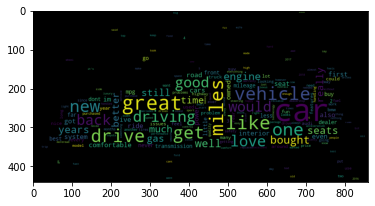

In [ ]:
from wordcloud import WordCloud
from PIL import Image
import matplotlib.pyplot as plt
car_mask = np.array(Image.open('/content/drive/MyDrive/fyp/R.png'))
wordcloud = WordCloud(background_color='black',
                      height=4000,
                      width=8000,
                      # max_words=1000,
                      max_font_size=80, 
                      mask=car_mask)
word_frequence = {x[0]:x[1] for x in words_stat.head(1000).values}
wordcloud = wordcloud.fit_words(word_frequence)
plt.imshow(wordcloud)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vec = TfidfVectorizer()
tfidf_matrix = tfidf_vec.fit_transform(filtered_words)
print(tfidf_vec.get_feature_names()) 
print(tfidf_vec.vocabulary_) # get the id for each words
print(tfidf_matrix.toarray())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['00', '000', '0018', '006', '007', '0075', '00s', '01', '010', '010219', '011922', '012021', '012022', '013', '014', '0162021', '01s', '01we', '02', '0221', '03', '03062019', '0308', '033', '03312019', '03ebpourgo', '03mdx', '04', '040', '04092016', '04162018', '04182021', '045', '04s', '04tl', '05', '050', '05092016', '0512', '05162016', '05s', '06', '060', '060116', '0607s', '0609', '060mph', '06222018', '0625', '06k115611d', '07', '070', '07112020', '071519', '07242020', '07lexusrx', '08', '08042018', '08062018', '08162018', '08182018', '082020', '08202018', '08242018', '09', '09062017', '09062018', '09072019', '090915', '0910', '092016', '0ctane', '0f', '0ne', '0opportunity', '0w20', '10', '100', '1000', '10000', '100000', '1000000', '10000010', '100000k', '10000k', '10000mi', '10001400', '1000k', '1000km', '1000s', '100100', '100120', '10012018', '100120mph', '100150000', '10019', '100200k', '10040', '100500', '1007', '100d', '100hp', '100k', '100km', '100kmiles', '100ksread', '1

### Split Train and Test

In [ ]:
from sklearn.model_selection import train_test_split
edmunds_train, edmunds_test = train_test_split(edmunds, test_size=0.2, random_state=42)

In [ ]:
print(len(edmunds_train))
print(len(edmunds_test))

9889
2473


##### Word Stem Extraction

In [ ]:
count_list = []
s = nltk.stem.SnowballStemmer('english') 
def stem_count(text):
  cleaned_text = []
  for i in range(len(text)):
    cleaned_text.append(s.stem(text[i]))
  count = Counter(text)
  return count
count_list.append(stem_count(filtered_words))

In [ ]:
count_list

[Counter({'4th': 80,
          'audi': 1307,
          'unfortunately': 122,
          'vehicle': 3681,
          'caused': 69,
          'problems': 1106,
          'far': 1403,
          'sexiest': 5,
          'car': 16815,
          'ever': 1139,
          'mechanics': 44,
          'identical': 27,
          'volkwagen': 2,
          'gti': 22,
          'lower': 253,
          'room': 928,
          'back': 2670,
          'much': 2011,
          'nicer': 71,
          'image': 17,
          'burn': 38,
          'lot': 1186,
          'oil': 920,
          'keep': 600,
          'eye': 106,
          'dip': 12,
          'stick': 106,
          'run': 325,
          'vins': 2,
          'check': 334,
          'intake': 36,
          'cam': 30,
          'high': 786,
          'output': 17,
          'fuel': 979,
          'pump': 192,
          'worked': 181,
          'denied': 14,
          'issues': 1203,
          'hundreds': 24,
          'angry': 12,
          'villagers'

save them for future use

In [ ]:
edmunds_train.to_csv('/content/drive/MyDrive/fyp/dataset/edmunds_train.csv')
edmunds_test.to_csv('/content/drive/MyDrive/fyp/dataset/edmunds_test.csv')

## Feature processing

In [4]:
import re
import math
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk import FreqDist
from nltk.stem import SnowballStemmer,WordNetLemmatizer
from textblob import TextBlob
from string import punctuation
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
import collections
import jieba
import pandas as pd
import numpy as np
import jieba.analyse
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline 
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image,ImageSequence
from sklearn import metrics
stoplist = stopwords.words('english')
stemmer=SnowballStemmer('english')
lemma=WordNetLemmatizer()
plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False  

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [5]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.metrics import accuracy_score,confusion_matrix,precision_recall_curve,average_precision_score,roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.metrics  import classification_report

In [6]:
edmunds = pd.read_csv('/content/drive/MyDrive/fyp/dataset/edmunds_tfidf.csv')
del edmunds['Unnamed: 0']
edmunds.head()

Car  Overall_rating  \
0  Used 2017 Audi A7             4.0   
1  Used 2017 Audi A7             5.0   
2  Used 2012 Audi A3             5.0   
3  Used 2017 Audi A7             5.0   
4  Used 2012 Audi A3             5.0   

                                            Title  \
0                                  Slick & Sporty   
1                                      Audiacious   
2               Second one - Might go for a third   
3                                      Rowdy Audi   
4  Nice dieselGate used car and so comfortable!!!   

                                                Type  \
0  Premium Plus quattro 4dr Sedan AWD (3.0L 6cyl ...   
1  Prestige quattro 4dr Sedan AWD (3.0L 6cyl S/C 8A)   
2  2.0T PZEV Premium 4dr Wagon (2.0L 4cyl Turbo 6AM)   
3  Premium Plus quattro 4dr Sedan AWD (3.0L 6cyl ...   
4       2.0T Premium 4dr Wagon (2.0L 4cyl Turbo 6AM)   

                                                Text             Owner  \
0  this is my 4th audi  unfortunately this vehicl...    Gregory Demler   
1             by far the sexiest car i have ever had          Audisome   
2  its mechanics are identical to a volkwagen gti...  The Amazing Marc   
3  all i can say is lets goits still worth more t...       Koolgeerapp   
4  i just purchased this after a test drive of ov...           Evan F.   

         Date  Safety  Technology  Performance  Interior Comfort  Reliability  \
0  12/18/2019     NaN         NaN          NaN       NaN     NaN          NaN   
1  08/20/2020     5.0         5.0          5.0       5.0       5          5.0   
2  11/02/2017     4.0         4.0          5.0       3.0       3          3.0   
3  10/06/2021     5.0         5.0          5.0       5.0       5          5.0   
4  04/17/2020     4.0         4.0          5.0       5.0       5          4.0   

   Value                                         Text_split  \
0    NaN  ['this', 'is', 'my', '4th', 'audi', 'unfortuna...   
1    5.0  ['by', 'far', 'the', 'sexiest', 'car', 'i', 'h...   
2    5.0  ['its', 'mechanics', 'are', 'identical', 'to',...   
3    5.0  ['all', 'i', 'can', 'say', 'is', 'lets', 'goit...   
4    5.0  ['i', 'just', 'purchased', 'this', 'after', 'a...   

                                              tf-idf  
0  {'caused': 0.86715, '4th': 0.84428, 'unfortuna...  
1  {'sexiest': 1.90766, 'ever': 0.62493, 'far': 0...  
2  {'volkwagen': 0.10952, 'vins': 0.10952, 'villa...  
3  {'goits': 1.04047, 'lets': 0.62544, '200': 0.5...  
4  {'signal': 0.04604, 'back': 0.04539, 'tire': 0...

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


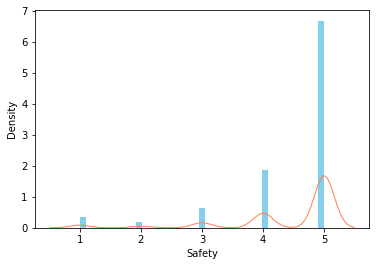

In [ ]:
import seaborn as sns
sns.distplot(edmunds['Safety'], 
             kde_kws={"color": "coral", "lw": 1, "label": "KDE"}, 
             hist_kws={"histtype": "stepfilled", "linewidth": 3, "alpha": 1, "color": "skyblue"})

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


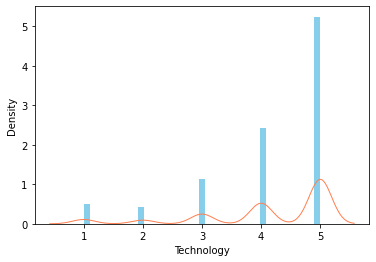

In [ ]:
sns.distplot(edmunds['Technology'], 
             kde_kws={"color": "coral", "lw": 1, "label": "KDE"}, 
             hist_kws={"histtype": "stepfilled", "linewidth": 3, "alpha": 1, "color": "skyblue"})

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


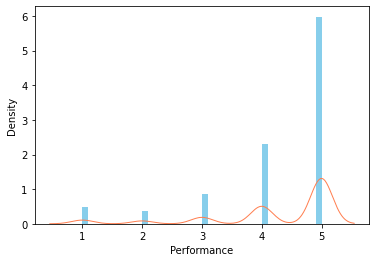

In [ ]:
sns.distplot(edmunds['Performance'], 
             kde_kws={"color": "coral", "lw": 1, "label": "KDE"}, 
             hist_kws={"histtype": "stepfilled", "linewidth": 3, "alpha": 1, "color": "skyblue"})

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


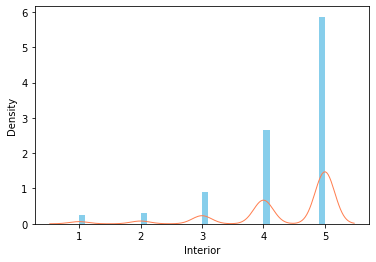

In [ ]:
sns.distplot(edmunds['Interior'], 
             kde_kws={"color": "coral", "lw": 1, "label": "KDE"}, 
             hist_kws={"histtype": "stepfilled", "linewidth": 3, "alpha": 1, "color": "skyblue"})

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


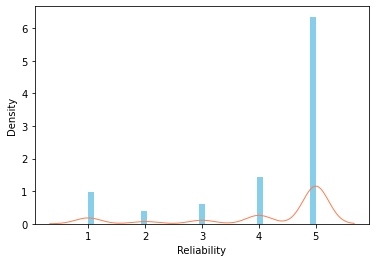

In [ ]:
sns.distplot(edmunds['Reliability'], 
             kde_kws={"color": "coral", "lw": 1, "label": "KDE"}, 
             hist_kws={"histtype": "stepfilled", "linewidth": 3, "alpha": 1, "color": "skyblue"})

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


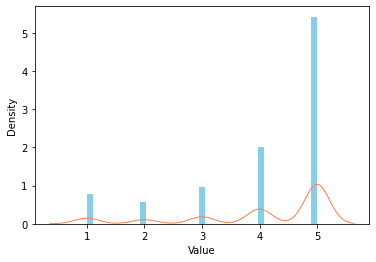

In [ ]:
sns.distplot(edmunds['Value'], 
             kde_kws={"color": "coral", "lw": 1, "label": "KDE"}, 
             hist_kws={"histtype": "stepfilled", "linewidth": 3, "alpha": 1, "color": "skyblue"})

In [ ]:
edmunds['Text1'] = edmunds['Text'].apply(lambda x : str(x).split('\n')[0])

In [ ]:
edmunds.to_excel('data.xlsx')

In [ ]:
def clean_review(review_col):
    review_corpus=[]
    for i in range(0,len(review_col)):
        review=str(review_col[i])
        review=re.sub('[^a-zA-Z]',' ',review)
        review=[lemma.lemmatize(w) for w in word_tokenize(str(review).lower()) if len(w)>2 and w not in stoplist]
        review=' '.join(review)
        review_corpus.append(review)
    print(len(review_corpus))
    return review_corpus

In [ ]:
edmunds['clean_review']=clean_review(edmunds['Text'].values)

12362


In [ ]:
edmunds1 = edmunds[pd.isna(edmunds['Safety']) != True]
edmunds1.index = range(edmunds1.shape[0])
edmunds1['Safety'] = edmunds1['Safety'].astype('int64')
edmunds1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Car  Overall_rating  \
0        Used 2017 Audi A7             5.0   
1        Used 2012 Audi A3             5.0   
2        Used 2017 Audi A7             5.0   
3        Used 2012 Audi A3             5.0   
4           2022 Acura ILX             5.0   
...                    ...             ...   
7209  Used 2006 Volvo XC70             5.0   
7210  Used 2005 Volvo XC70             5.0   
7211  Used 2005 Volvo XC70             5.0   
7212  Used 2004 Volvo XC70             5.0   
7213  Used 2004 Volvo XC70             3.0   

                                               Title  \
0                                         Audiacious   
1                  Second one - Might go for a third   
2                                         Rowdy Audi   
3     Nice dieselGate used car and so comfortable!!!   
4                 My Opinion: Great Value, Great Car   
...                                              ...   
7209                                       Great car   
7210                                Volvo - For Life   
7211                                  I love my XC70   
7212                     Best car I have ever owned!   
7213                      2004 XC Wagon with 199,000   

                                                   Type  \
0     Prestige quattro 4dr Sedan AWD (3.0L 6cyl S/C 8A)   
1     2.0T PZEV Premium 4dr Wagon (2.0L 4cyl Turbo 6AM)   
2     Premium Plus quattro 4dr Sedan AWD (3.0L 6cyl ...   
3          2.0T Premium 4dr Wagon (2.0L 4cyl Turbo 6AM)   
4     4dr Sedan w/Premium and A-Spec Packages (2.4L ...   
...                                                 ...   
7209  Volvo Ocean Race Edition 4dr Wagon AWD (2.5L 5...   
7210                 AWD 4dr Wagon (2.5L 5cyl Turbo 5A)   
7211                 AWD 4dr Wagon (2.5L 5cyl Turbo 5A)   
7212                 AWD 4dr Wagon (2.5L 5cyl Turbo 5A)   
7213                 AWD 4dr Wagon (2.5L 5cyl Turbo 5A)   

                                                   Text  \
0                by far the sexiest car i have ever had   
1     its mechanics are identical to a volkwagen gti...   
2     all i can say is lets goits still worth more t...   
3     i just purchased this after a test drive of ov...   
4     i just purchased a 2022 acura ilx premium wasp...   
...                                                 ...   
7209  180000 miles love car in snow plenty of power ...   
7210  i loved my 2005 volvo xc70 everything about th...   
7211  first of all its a beautifully styled car very...   
7212  i have always loved the way the xc70 has looke...   
7213  i read review by bruce from charlotte detailin...   

                      Owner        Date  Safety  Technology  Performance  \
0                  Audisome  08/20/2020       5         5.0          5.0   
1          The Amazing Marc  11/02/2017       4         4.0          5.0   
2               Koolgeerapp  10/06/2021       5         5.0          5.0   
3                   Evan F.  04/17/2020       4         4.0          5.0   
4                      DF10  12/18/2021       5         4.0          5.0   
...                     ...         ...     ...         ...          ...   
7209                  Jerry  10/02/2015       5         4.0          5.0   
7210          VolvoXCdriver  05/19/2016       5         5.0          5.0   
7211            Rick Pascal  05/11/2016       5         5.0          5.0   
7212               shiner42  05/23/2015       5         5.0          5.0   
7213  waters802@hotmail.com  09/13/2016       5         3.0          3.0   

      Interior Comfort  Reliability  Value  \
0          5.0       5          5.0    5.0   
1          3.0       3          3.0    5.0   
2          5.0       5          5.0    5.0   
3          5.0       5          4.0    5.0   
4          4.0       4          5.0    5.0   
...        ...     ...          ...    ...   
7209       5.0       5          NaN    NaN   
7210       5.0       5          5.0    5.0   
7211       5.0       5          5.0    5.0   
7212  

In [ ]:
edmunds1.to_csv('edmunds1.csv')

## Bayes

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 5)]

max_features = ['auto', 'sqrt']

max_depth = [int(x) for x in np.linspace(5, 50, num = 10)]
max_depth.append(None)

min_samples_split = [2, 5, 10]

min_samples_leaf = [ 2, 4]

bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [100, 325, 550, 775, 1000], 'max_features': ['auto', 'sqrt'], 'max_depth': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [2, 4], 'bootstrap': [True, False]}


In [ ]:
from sklearn.ensemble import RandomForestRegressor
name = "Safety"
edmunds1 = edmunds[pd.isna(edmunds[name]) != True]
edmunds1.index = range(edmunds1.shape[0])
edmunds1[name] = edmunds1[name].astype('int64')
counter = CountVectorizer(max_df=0.8, min_df=4)
counts = counter.fit_transform(edmunds1['clean_review'].values.tolist())
tfidfer = TfidfTransformer()
x = tfidfer.fit_transform(counts)
word=counter.get_feature_names()
y = edmunds1[name]
X_train, X_test, y_train, y_test = train_test_split(x,y,random_state=1)

rf = RandomForestRegressor()

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 50, cv = 2, verbose=2, random_state=42, n_jobs = -1)

rf_random.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Fitting 2 folds for each of 50 candidates, totalling 100 fits


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


KeyboardInterrupt: ignored

In [ ]:
rf_random.best_params_

AttributeError: ignored

### Safety

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Bayes: 0.6740576496674058
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        68
           2       0.00      0.00      0.00        30
           3       0.00      0.00      0.00       126
           4       0.33      0.01      0.01       365
           5       0.68      1.00      0.81      1215

    accuracy                           0.67      1804
   macro avg       0.20      0.20      0.16      1804
weighted avg       0.52      0.67      0.54      1804



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetric

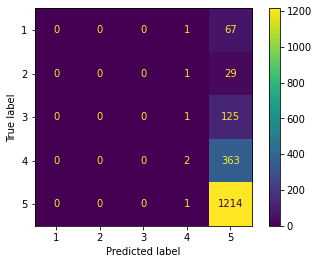

In [ ]:
name = "Safety"
edmunds1 = edmunds[pd.isna(edmunds[name]) != True]
edmunds1.index = range(edmunds1.shape[0])
edmunds1[name] = edmunds1[name].astype('int64')
counter = CountVectorizer(max_df=0.8, min_df=4)
counts = counter.fit_transform(edmunds1['clean_review'].values.tolist())
tfidfer = TfidfTransformer()
x = tfidfer.fit_transform(counts)
word=counter.get_feature_names()
y = edmunds1[name]
X_train, X_test, y_train, y_test = train_test_split(x,y,random_state=1)
clf = MultinomialNB().fit(X_train, y_train)
print('Bayes:',clf.score(X_test, y_test))
pre = clf.predict(X_test)
print(classification_report(y_test,pre))
metrics.plot_confusion_matrix(clf, X_test, y_test)

### Technology

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Bayes: 0.5362479247371333
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        99
           2       0.00      0.00      0.00        69
           3       0.00      0.00      0.00       210
           4       0.27      0.03      0.05       469
           5       0.54      1.00      0.70       960

    accuracy                           0.54      1807
   macro avg       0.16      0.20      0.15      1807
weighted avg       0.36      0.54      0.39      1807



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetric

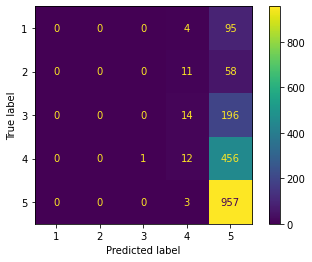

In [ ]:
name = "Technology"
edmunds1 = edmunds[pd.isna(edmunds[name]) != True]
edmunds1.index = range(edmunds1.shape[0])
edmunds1[name] = edmunds1[name].astype('int64')
counter = CountVectorizer(max_df=0.8, min_df=4)
counts = counter.fit_transform(edmunds1['clean_review'].values.tolist())
tfidfer = TfidfTransformer()
x = tfidfer.fit_transform(counts)
word=counter.get_feature_names()
y = edmunds1[name]
X_train, X_test, y_train, y_test = train_test_split(x,y,random_state=1)
clf = MultinomialNB().fit(X_train, y_train)
print('Bayes:',clf.score(X_test, y_test))
pre = clf.predict(X_test)
print(classification_report(y_test,pre))
metrics.plot_confusion_matrix(clf, X_test, y_test)

### Performance

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Bayes: 0.5854414042333506
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       104
           2       0.00      0.00      0.00        74
           3       0.00      0.00      0.00       168
           4       0.08      0.00      0.01       453
           5       0.59      0.99      0.74      1138

    accuracy                           0.59      1937
   macro avg       0.13      0.20      0.15      1937
weighted avg       0.37      0.59      0.44      1937



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetric

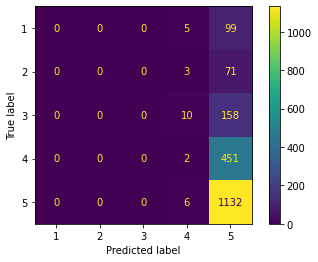

In [ ]:
name = "Performance"
edmunds1 = edmunds[pd.isna(edmunds[name]) != True]
edmunds1.index = range(edmunds1.shape[0])
edmunds1[name] = edmunds1[name].astype('int64')
counter = CountVectorizer(max_df=0.8, min_df=4)
counts = counter.fit_transform(edmunds1['clean_review'].values.tolist())
tfidfer = TfidfTransformer()
x = tfidfer.fit_transform(counts)
word=counter.get_feature_names()
y = edmunds1[name]
X_train, X_test, y_train, y_test = train_test_split(x,y,random_state=1)
clf = MultinomialNB().fit(X_train, y_train)
print('Bayes:',clf.score(X_test, y_test))
pre = clf.predict(X_test)
print(classification_report(y_test,pre))
metrics.plot_confusion_matrix(clf, X_test, y_test)

### Interior

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Bayes: 0.5760986066452305
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        51
           2       0.00      0.00      0.00        57
           3       0.00      0.00      0.00       178
           4       0.29      0.05      0.09       507
           5       0.59      0.98      0.74      1073

    accuracy                           0.58      1866
   macro avg       0.18      0.21      0.17      1866
weighted avg       0.42      0.58      0.45      1866



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetric

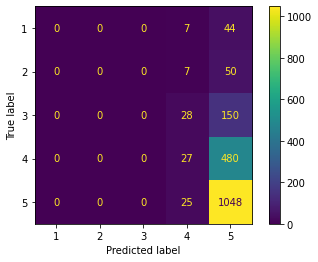

In [ ]:
name = "Interior"
edmunds1 = edmunds[pd.isna(edmunds[name]) != True]
edmunds1.index = range(edmunds1.shape[0])
edmunds1[name] = edmunds1[name].astype('int64')
counter = CountVectorizer(max_df=0.8, min_df=4)
counts = counter.fit_transform(edmunds1['clean_review'].values.tolist())
tfidfer = TfidfTransformer()
x = tfidfer.fit_transform(counts)
word=counter.get_feature_names()
y = edmunds1[name]
X_train, X_test, y_train, y_test = train_test_split(x,y,random_state=1)
clf = MultinomialNB().fit(X_train, y_train)
print('Bayes:',clf.score(X_test, y_test))
pre = clf.predict(X_test)
print(classification_report(y_test,pre))
metrics.plot_confusion_matrix(clf, X_test, y_test)

### Comfort

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Bayes: 0.582238570677877
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        64
           2       0.00      0.00      0.00        58
           3       0.00      0.00      0.00       174
           4       0.40      0.03      0.06       508
           5       0.59      0.99      0.74      1099

    accuracy                           0.58      1903
   macro avg       0.20      0.21      0.16      1903
weighted avg       0.45      0.58      0.44      1903



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetric

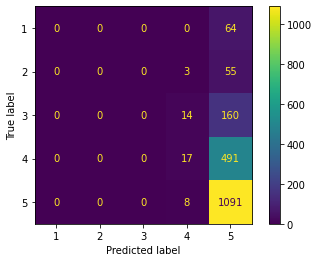

In [ ]:
name = "Comfort"
edmunds1 = edmunds[(pd.isna(edmunds[name]) != True) & (edmunds[name]!='H')]
edmunds1.index = range(edmunds1.shape[0])
edmunds1[name] = edmunds1[name].astype('int64')
counter = CountVectorizer(max_df=0.8, min_df=4)
counts = counter.fit_transform(edmunds1['clean_review'].values.tolist())
tfidfer = TfidfTransformer()
x = tfidfer.fit_transform(counts)
word=counter.get_feature_names()
y = edmunds1[name]
X_train, X_test, y_train, y_test = train_test_split(x,y,random_state=1)
clf = MultinomialNB().fit(X_train, y_train)
print('Bayes:',clf.score(X_test, y_test))
pre = clf.predict(X_test)
print(classification_report(y_test,pre))
metrics.plot_confusion_matrix(clf, X_test, y_test)

### Reliability

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Bayes: 0.6805239179954442
              precision    recall  f1-score   support

           1       0.81      0.24      0.38       188
           2       0.00      0.00      0.00        69
           3       0.00      0.00      0.00        93
           4       0.00      0.00      0.00       253
           5       0.68      1.00      0.81      1153

    accuracy                           0.68      1756
   macro avg       0.30      0.25      0.24      1756
weighted avg       0.53      0.68      0.57      1756



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetric

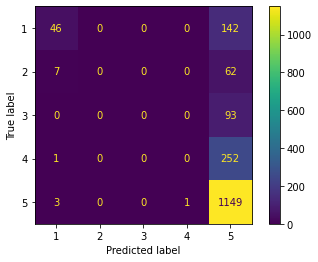

In [ ]:
name = "Reliability"
edmunds1 = edmunds[pd.isna(edmunds[name]) != True]
edmunds1.index = range(edmunds1.shape[0])
edmunds1[name] = edmunds1[name].astype('int64')
counter = CountVectorizer(max_df=0.8, min_df=4)
counts = counter.fit_transform(edmunds1['clean_review'].values.tolist())
tfidfer = TfidfTransformer()
x = tfidfer.fit_transform(counts)
word=counter.get_feature_names()
y = edmunds1[name]
X_train, X_test, y_train, y_test = train_test_split(x,y,random_state=1)
clf = MultinomialNB().fit(X_train, y_train)
print('Bayes:',clf.score(X_test, y_test))
pre = clf.predict(X_test)
print(classification_report(y_test,pre))
metrics.plot_confusion_matrix(clf, X_test, y_test)

### Value

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Bayes: 0.5596120935539076
              precision    recall  f1-score   support

           1       0.80      0.08      0.15       147
           2       0.00      0.00      0.00       111
           3       1.00      0.01      0.02       171
           4       0.00      0.00      0.00       354
           5       0.56      1.00      0.72       970

    accuracy                           0.56      1753
   macro avg       0.47      0.22      0.18      1753
weighted avg       0.47      0.56      0.41      1753



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetric

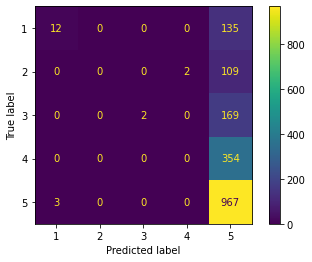

In [ ]:
name = "Value"
edmunds1 = edmunds[pd.isna(edmunds[name]) != True]
edmunds1.index = range(edmunds1.shape[0])
edmunds1[name] = edmunds1[name].astype('int64')
counter = CountVectorizer(max_df=0.8, min_df=4)
counts = counter.fit_transform(edmunds1['clean_review'].values.tolist())
tfidfer = TfidfTransformer()
x = tfidfer.fit_transform(counts)
word=counter.get_feature_names()
y = edmunds1[name]
X_train, X_test, y_train, y_test = train_test_split(x,y,random_state=1)
clf = MultinomialNB().fit(X_train, y_train)
print('Bayes:',clf.score(X_test, y_test))
pre = clf.predict(X_test)
print(classification_report(y_test,pre))
metrics.plot_confusion_matrix(clf, X_test, y_test)

## SVM

### Safety

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


SVM： 0.6735033259423503


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        68
           2       0.00      0.00      0.00        30
           3       0.00      0.00      0.00       126
           4       0.00      0.00      0.00       365
           5       0.67      1.00      0.81      1215

    accuracy                           0.67      1804
   macro avg       0.13      0.20      0.16      1804
weighted avg       0.45      0.67      0.54      1804



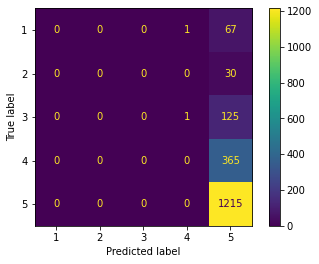

In [ ]:
name = "Safety"
edmunds1 = edmunds[pd.isna(edmunds[name]) != True]
edmunds1.index = range(edmunds1.shape[0])
edmunds1[name] = edmunds1[name].astype('int64')
counter = CountVectorizer(max_df=0.8, min_df=4)
counts = counter.fit_transform(edmunds1['clean_review'].values.tolist())
tfidfer = TfidfTransformer()
x = tfidfer.fit_transform(counts)
word=counter.get_feature_names()
y = edmunds1[name]
X_train, X_test, y_train, y_test = train_test_split(x,y,random_state=1)
clf = SVC(probability=True).fit(X_train, y_train)
print('SVM：',clf.score(X_test, y_test))
pre = clf.predict(X_test)
print(classification_report(y_test,pre))
metrics.plot_confusion_matrix(clf, X_test, y_test)

### Technology

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


SVM： 0.5384615384615384


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py

              precision    recall  f1-score   support

           1       0.67      0.04      0.08        99
           2       0.00      0.00      0.00        69
           3       0.30      0.04      0.07       210
           4       0.25      0.03      0.06       469
           5       0.55      0.99      0.71       960

    accuracy                           0.54      1807
   macro avg       0.35      0.22      0.18      1807
weighted avg       0.43      0.54      0.40      1807



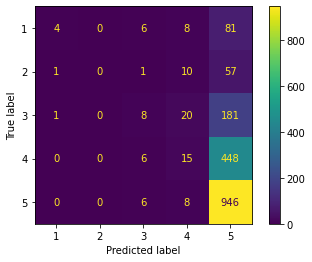

In [ ]:
name = "Technology"
edmunds1 = edmunds[pd.isna(edmunds[name]) != True]
edmunds1.index = range(edmunds1.shape[0])
edmunds1[name] = edmunds1[name].astype('int64')
counter = CountVectorizer(max_df=0.8, min_df=4)
counts = counter.fit_transform(edmunds1['clean_review'].values.tolist())
tfidfer = TfidfTransformer()
x = tfidfer.fit_transform(counts)
word=counter.get_feature_names()
y = edmunds1[name]
X_train, X_test, y_train, y_test = train_test_split(x,y,random_state=1)
clf = SVC(probability=True).fit(X_train, y_train)
print('SVM：',clf.score(X_test, y_test))
pre = clf.predict(X_test)
print(classification_report(y_test,pre))
metrics.plot_confusion_matrix(clf, X_test, y_test)

### Performance

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


SVM： 0.586473928755808
              precision    recall  f1-score   support

           1       0.35      0.06      0.10       104
           2       0.00      0.00      0.00        74
           3       0.10      0.01      0.01       168
           4       0.15      0.02      0.03       453
           5       0.60      0.99      0.75      1138

    accuracy                           0.59      1937
   macro avg       0.24      0.21      0.18      1937
weighted avg       0.42      0.59      0.45      1937



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


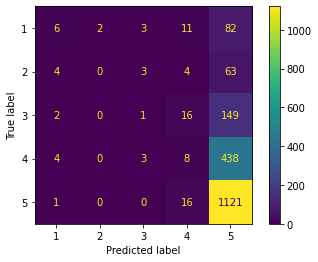

In [ ]:
name = "Performance"
edmunds1 = edmunds[pd.isna(edmunds[name]) != True]
edmunds1.index = range(edmunds1.shape[0])
edmunds1[name] = edmunds1[name].astype('int64')
counter = CountVectorizer(max_df=0.8, min_df=4)
counts = counter.fit_transform(edmunds1['clean_review'].values.tolist())
tfidfer = TfidfTransformer()
x = tfidfer.fit_transform(counts)
word=counter.get_feature_names()
y = edmunds1[name]
X_train, X_test, y_train, y_test = train_test_split(x,y,random_state=1)
clf = SVC(probability=True).fit(X_train, y_train)
print('SVM：',clf.score(X_test, y_test))
pre = clf.predict(X_test)
print(classification_report(y_test,pre))
metrics.plot_confusion_matrix(clf, X_test, y_test)

### Interior

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


SVM： 0.5777063236870311


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        51
           2       0.00      0.00      0.00        57
           3       0.00      0.00      0.00       178
           4       0.34      0.09      0.15       507
           5       0.60      0.96      0.74      1073

    accuracy                           0.58      1866
   macro avg       0.19      0.21      0.18      1866
weighted avg       0.44      0.58      0.46      1866



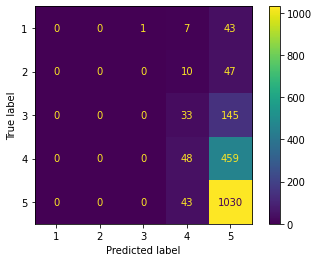

In [ ]:
name = "Interior"
edmunds1 = edmunds[pd.isna(edmunds[name]) != True]
edmunds1.index = range(edmunds1.shape[0])
edmunds1[name] = edmunds1[name].astype('int64')
counter = CountVectorizer(max_df=0.8, min_df=4)
counts = counter.fit_transform(edmunds1['clean_review'].values.tolist())
tfidfer = TfidfTransformer()
x = tfidfer.fit_transform(counts)
word=counter.get_feature_names()
y = edmunds1[name]
X_train, X_test, y_train, y_test = train_test_split(x,y,random_state=1)
clf = SVC(probability=True).fit(X_train, y_train)
print('SVM：',clf.score(X_test, y_test))
pre = clf.predict(X_test)
print(classification_report(y_test,pre))
metrics.plot_confusion_matrix(clf, X_test, y_test)

### Comfort

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


SVM： 0.5880189174986863


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        64
           2       0.00      0.00      0.00        58
           3       1.00      0.01      0.01       174
           4       0.43      0.06      0.11       508
           5       0.59      0.99      0.74      1099

    accuracy                           0.59      1903
   macro avg       0.40      0.21      0.17      1903
weighted avg       0.55      0.59      0.46      1903



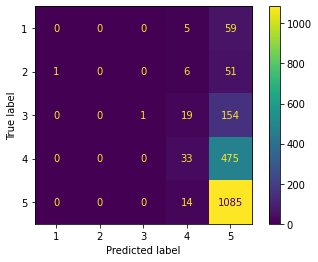

In [ ]:
name = "Comfort"
edmunds1 = edmunds[pd.isna(edmunds[name]) != True  & (edmunds[name]!='H')]
edmunds1.index = range(edmunds1.shape[0])
edmunds1[name] = edmunds1[name].astype('int64')
counter = CountVectorizer(max_df=0.8, min_df=4)
counts = counter.fit_transform(edmunds1['clean_review'].values.tolist())
tfidfer = TfidfTransformer()
x = tfidfer.fit_transform(counts)
word=counter.get_feature_names()
y = edmunds1[name]
X_train, X_test, y_train, y_test = train_test_split(x,y,random_state=1)
clf = SVC(probability=True).fit(X_train, y_train)
print('SVM：',clf.score(X_test, y_test))
pre = clf.predict(X_test)
print(classification_report(y_test,pre))
metrics.plot_confusion_matrix(clf, X_test, y_test)

### Reliability

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


SVM： 0.7164009111617312


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py

              precision    recall  f1-score   support

           1       0.60      0.60      0.60       188
           2       0.00      0.00      0.00        69
           3       0.00      0.00      0.00        93
           4       0.00      0.00      0.00       253
           5       0.73      0.99      0.84      1153

    accuracy                           0.72      1756
   macro avg       0.27      0.32      0.29      1756
weighted avg       0.54      0.72      0.62      1756



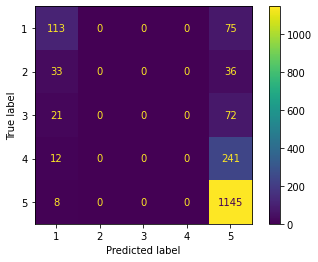

In [ ]:
name = "Reliability"
edmunds1 = edmunds[pd.isna(edmunds[name]) != True]
edmunds1.index = range(edmunds1.shape[0])
edmunds1[name] = edmunds1[name].astype('int64')
counter = CountVectorizer(max_df=0.8, min_df=4)
counts = counter.fit_transform(edmunds1['clean_review'].values.tolist())
tfidfer = TfidfTransformer()
x = tfidfer.fit_transform(counts)
word=counter.get_feature_names()
y = edmunds1[name]
X_train, X_test, y_train, y_test = train_test_split(x,y,random_state=1)
clf = SVC(probability=True).fit(X_train, y_train)
print('SVM：',clf.score(X_test, y_test))
pre = clf.predict(X_test)
print(classification_report(y_test,pre))
metrics.plot_confusion_matrix(clf, X_test, y_test)

### Value

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


SVM： 0.5926982316029663
              precision    recall  f1-score   support

           1       0.51      0.45      0.48       147
           2       0.00      0.00      0.00       111
           3       0.29      0.06      0.11       171
           4       0.29      0.01      0.01       354
           5       0.61      0.99      0.75       970

    accuracy                           0.59      1753
   macro avg       0.34      0.30      0.27      1753
weighted avg       0.47      0.59      0.47      1753



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


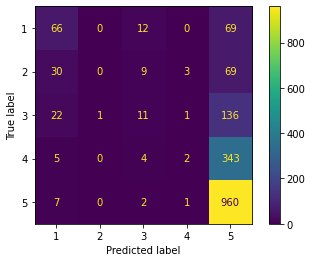

In [ ]:
name = "Value"
edmunds1 = edmunds[pd.isna(edmunds[name]) != True]
edmunds1.index = range(edmunds1.shape[0])
edmunds1[name] = edmunds1[name].astype('int64')
counter = CountVectorizer(max_df=0.8, min_df=4)
counts = counter.fit_transform(edmunds1['clean_review'].values.tolist())
tfidfer = TfidfTransformer()
x = tfidfer.fit_transform(counts)
word=counter.get_feature_names()
y = edmunds1[name]
X_train, X_test, y_train, y_test = train_test_split(x,y,random_state=1)
clf = SVC(probability=True).fit(X_train, y_train)
print('SVM：',clf.score(X_test, y_test))
pre = clf.predict(X_test)
print(classification_report(y_test,pre))
metrics.plot_confusion_matrix(clf, X_test, y_test)

## SVM Improvement

In [7]:
df = pd.read_csv('/content/drive/MyDrive/fyp/dataset/edmunds_tfidf.csv')
del df['Unnamed: 0']

In [8]:
df['Text1'] = df['Text'].apply(lambda x : str(x).split('\n')[0])

In [9]:
def clean_review(review_col):
    review_corpus=[]
    for i in range(0,len(review_col)):
        review=str(review_col[i])
        review=re.sub('[^a-zA-Z]',' ',review)
        review=[lemma.lemmatize(w) for w in word_tokenize(str(review).lower()) if len(w)>2 and w not in stoplist]
        review=' '.join(review)
        review_corpus.append(review)
    return review_corpus

In [10]:
df['clean_review']=clean_review(df['Text'].values)

In [11]:
df1 = df[pd.isna(df['Safety']) != True]
df1.index = range(df1.shape[0])
df1['Safety'] = df1['Safety'].astype('int64')
df1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Car  Overall_rating  \
0        Used 2017 Audi A7             5.0   
1        Used 2012 Audi A3             5.0   
2        Used 2017 Audi A7             5.0   
3        Used 2012 Audi A3             5.0   
4           2022 Acura ILX             5.0   
...                    ...             ...   
7209  Used 2006 Volvo XC70             5.0   
7210  Used 2005 Volvo XC70             5.0   
7211  Used 2005 Volvo XC70             5.0   
7212  Used 2004 Volvo XC70             5.0   
7213  Used 2004 Volvo XC70             3.0   

                                               Title  \
0                                         Audiacious   
1                  Second one - Might go for a third   
2                                         Rowdy Audi   
3     Nice dieselGate used car and so comfortable!!!   
4                 My Opinion: Great Value, Great Car   
...                                              ...   
7209                                       Great car   
7210                                Volvo - For Life   
7211                                  I love my XC70   
7212                     Best car I have ever owned!   
7213                      2004 XC Wagon with 199,000   

                                                   Type  \
0     Prestige quattro 4dr Sedan AWD (3.0L 6cyl S/C 8A)   
1     2.0T PZEV Premium 4dr Wagon (2.0L 4cyl Turbo 6AM)   
2     Premium Plus quattro 4dr Sedan AWD (3.0L 6cyl ...   
3          2.0T Premium 4dr Wagon (2.0L 4cyl Turbo 6AM)   
4     4dr Sedan w/Premium and A-Spec Packages (2.4L ...   
...                                                 ...   
7209  Volvo Ocean Race Edition 4dr Wagon AWD (2.5L 5...   
7210                 AWD 4dr Wagon (2.5L 5cyl Turbo 5A)   
7211                 AWD 4dr Wagon (2.5L 5cyl Turbo 5A)   
7212                 AWD 4dr Wagon (2.5L 5cyl Turbo 5A)   
7213                 AWD 4dr Wagon (2.5L 5cyl Turbo 5A)   

                                                   Text  \
0                by far the sexiest car i have ever had   
1     its mechanics are identical to a volkwagen gti...   
2     all i can say is lets goits still worth more t...   
3     i just purchased this after a test drive of ov...   
4     i just purchased a 2022 acura ilx premium wasp...   
...                                                 ...   
7209  180000 miles love car in snow plenty of power ...   
7210  i loved my 2005 volvo xc70 everything about th...   
7211  first of all its a beautifully styled car very...   
7212  i have always loved the way the xc70 has looke...   
7213  i read review by bruce from charlotte detailin...   

                      Owner        Date  Safety  Technology  Performance  \
0                  Audisome  08/20/2020       5         5.0          5.0   
1          The Amazing Marc  11/02/2017       4         4.0          5.0   
2               Koolgeerapp  10/06/2021       5         5.0          5.0   
3                   Evan F.  04/17/2020       4         4.0          5.0   
4                      DF10  12/18/2021       5         4.0          5.0   
...                     ...         ...     ...         ...          ...   
7209                  Jerry  10/02/2015       5         4.0          5.0   
7210          VolvoXCdriver  05/19/2016       5         5.0          5.0   
7211            Rick Pascal  05/11/2016       5         5.0          5.0   
7212               shiner42  05/23/2015       5         5.0          5.0   
7213  waters802@hotmail.com  09/13/2016       5         3.0          3.0   

      Interior Comfort  Reliability  Value  \
0          5.0       5          5.0    5.0   
1          3.0       3          3.0    5.0   
2          5.0       5          5.0    5.0   
3          5.0       5          4.0    5.0   
4          4.0       4          5.0    5.0   
...        ...     ...          ...    ...   
7209       5.0       5          NaN    NaN   
7210       5.0       5          5.0    5.0   
7211       5.0       5          5.0    5.0   
7212  

In [12]:
def kn(x):
    if x >2:
        return 1
    return 0

In [ ]:
edmunds['Reliability'].value_counts()

5.0    4572
4.0    1025
1.0     713
3.0     431
2.0     281
Name: Reliability, dtype: int64

### Safety

In [13]:
# from sklearn.ensemble import RandomForestRegressor
# name = "Safety"
# df1 = df[pd.isna(df[name]) != True]
# df1.index = range(df1.shape[0])
# df1[name] = df1[name].astype('int64')
# df1[name] = df1[name] .apply(lambda x : kn(x))
# d1 = df1[df1[name]==1].sample(883)
# d2 = df1[df1[name]==0].sample(df1[df1[name]==0].shape[0])
# df1 = pd.concat([d1,d2])
# df1.index = range(df1.shape[0])
# counter = CountVectorizer(max_df=0.8, min_df=4)
# counts = counter.fit_transform(df1['clean_review'].values.tolist())
# tfidfer = TfidfTransformer()
# x = tfidfer.fit_transform(counts)
# word = counter.get_feature_names()
# y = df1[name]

# X_train, X_test, y_train, y_test = train_test_split(x,y,random_state=1)

# rf = RandomForestRegressor()

# rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 50, cv = 2, verbose=2, random_state=42, n_jobs = -1)

# rf_random.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


NameError: ignored

In [ ]:
rf_random.best_params_

{'bootstrap': False,
 'max_depth': 40,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 325}

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.w

svm： 0.8229813664596274
              precision    recall  f1-score   support

           0       0.87      0.55      0.67       107
           1       0.81      0.96      0.88       215

    accuracy                           0.82       322
   macro avg       0.84      0.75      0.78       322
weighted avg       0.83      0.82      0.81       322



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


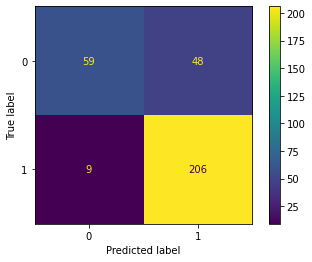

In [16]:
name = "Safety"
df1 = df[pd.isna(df[name]) != True]
df1.index = range(df1.shape[0])
df1[name] = df1[name].astype('int64')
df1[name] = df1[name] .apply(lambda x : kn(x))
d1 = df1[df1[name]==1].sample(883)
d2 = df1[df1[name]==0].sample(df1[df1[name]==0].shape[0])
df1 = pd.concat([d1,d2])
df1.index = range(df1.shape[0])
counter = CountVectorizer(max_df=0.8, min_df=4)
counts = counter.fit_transform(df1['clean_review'].values.tolist())
tfidfer = TfidfTransformer()
x = tfidfer.fit_transform(counts)
word = counter.get_feature_names()
y = df1[name]

X_train, X_test, y_train, y_test = train_test_split(x,y,random_state=1)

clf = SVC(probability=True).fit(X_train, y_train)
print('svm：',clf.score(X_test, y_test))
pre = clf.predict(X_test)
print(classification_report(y_test,pre))
metrics.plot_confusion_matrix(clf, X_test, y_test)

### Technology

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn

svm： 0.7911275415896488
              precision    recall  f1-score   support

           0       0.74      0.52      0.61       170
           1       0.81      0.92      0.86       371

    accuracy                           0.79       541
   macro avg       0.77      0.72      0.73       541
weighted avg       0.78      0.79      0.78       541



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


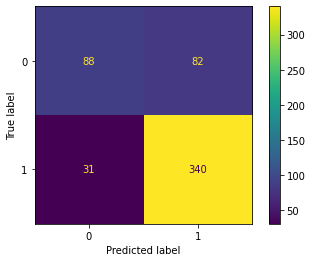

In [17]:
name = "Technology"
df1 = df[pd.isna(df[name]) != True]
df1.index = range(df1.shape[0])
df1[name] = df1[name].astype('int64')

df1[name] = df1[name] .apply(lambda x : kn(x))
d1 = df1[df1[name]==1].sample(1469)
d2 = df1[df1[name]==0].sample(df1[df1[name]==0].shape[0])
df1 = pd.concat([d1,d2])
df1.index = range(df1.shape[0])

counter = CountVectorizer(max_df=0.8, min_df=4)
counts = counter.fit_transform(df1['clean_review'].values.tolist())
tfidfer = TfidfTransformer()
x = tfidfer.fit_transform(counts)
word=counter.get_feature_names()
y = df1[name]
X_train, X_test, y_train, y_test = train_test_split(x,y,random_state=1)
clf = SVC().fit(X_train, y_train)
print('svm：',clf.score(X_test, y_test))
pre = clf.predict(X_test)
print(classification_report(y_test,pre))
metrics.plot_confusion_matrix(clf, X_test, y_test)

### Performance

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn

svm： 0.8404255319148937
              precision    recall  f1-score   support

           0       0.88      0.63      0.74       166
           1       0.83      0.95      0.89       304

    accuracy                           0.84       470
   macro avg       0.85      0.79      0.81       470
weighted avg       0.85      0.84      0.83       470



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


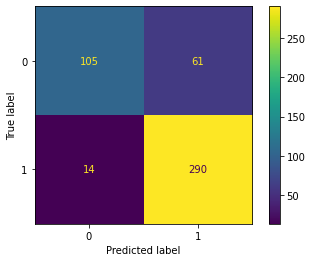

In [18]:
name = "Performance"
df1 = df[pd.isna(df[name]) != True]
df1.index = range(df1.shape[0])
df1[name] = df1[name].astype('int64')

df1[name] = df1[name] .apply(lambda x : kn(x))
d1 = df1[df1[name]==1].sample(1207)
d2 = df1[df1[name]==0].sample(df1[df1[name]==0].shape[0])
df1 = pd.concat([d1,d2])
df1.index = range(df1.shape[0])

counter = CountVectorizer(max_df=0.8, min_df=4)
counts = counter.fit_transform(df1['clean_review'].values.tolist())
tfidfer = TfidfTransformer()
x = tfidfer.fit_transform(counts)
word=counter.get_feature_names()
y = df1[name]
X_train, X_test, y_train, y_test = train_test_split(x,y,random_state=1)
clf = SVC().fit(X_train, y_train)
print('svm：',clf.score(X_test, y_test))
pre = clf.predict(X_test)
print(classification_report(y_test,pre))
metrics.plot_confusion_matrix(clf, X_test, y_test)

### Interior

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn

svm： 0.7170868347338936
              precision    recall  f1-score   support

           0       0.80      0.04      0.07       104
           1       0.72      1.00      0.83       253

    accuracy                           0.72       357
   macro avg       0.76      0.52      0.45       357
weighted avg       0.74      0.72      0.61       357



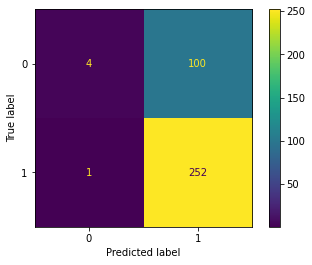

In [19]:
name = "Interior"
df1 = df[pd.isna(df[name]) != True]
df1.index = range(df1.shape[0])
df1[name] = df1[name].astype('int64')

df1[name] = df1[name] .apply(lambda x : kn(x))
d1 = df1[df1[name]==1].sample(1013)
d2 = df1[df1[name]==0].sample(df1[df1[name]==0].shape[0])
df1 = pd.concat([d1,d2])
df1.index = range(df1.shape[0])

counter = CountVectorizer(max_df=0.8, min_df=4)
counts = counter.fit_transform(df1['clean_review'].values.tolist())
tfidfer = TfidfTransformer()
x = tfidfer.fit_transform(counts)
word=counter.get_feature_names()
y = df1[name]
X_train, X_test, y_train, y_test = train_test_split(x,y,random_state=1)
clf = MultinomialNB().fit(X_train, y_train)
print('svm：',clf.score(X_test, y_test))
pre = clf.predict(X_test)
print(classification_report(y_test,pre))
metrics.plot_confusion_matrix(clf, X_test, y_test)

### Comfort

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.w

svm： 0.7945945945945946
              precision    recall  f1-score   support

           0       0.79      0.41      0.54       108
           1       0.80      0.95      0.87       262

    accuracy                           0.79       370
   macro avg       0.79      0.68      0.70       370
weighted avg       0.79      0.79      0.77       370



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


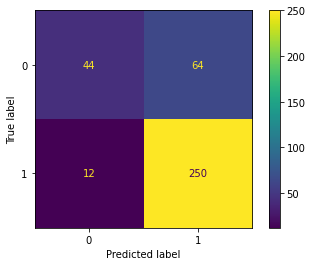

In [22]:
name = "Comfort"
df1 = df[(pd.isna(df[name]) != True) & (df[name]!='H')]
df1.index = range(df1.shape[0])
df1[name] = df1[name].astype('int64')
df1[name] = df1[name] .apply(lambda x : kn(x))
d1 = df1[df1[name]==1].sample(1040)
d2 = df1[df1[name]==0].sample(df1[df1[name]==0].shape[0])
df1 = pd.concat([d1,d2])
df1.index = range(df1.shape[0])

counter = CountVectorizer(max_df=0.8, min_df=4)
counts = counter.fit_transform(df1['clean_review'].values.tolist())
tfidfer = TfidfTransformer()
x = tfidfer.fit_transform(counts)
word=counter.get_feature_names()
y = df1[name]
X_train, X_test, y_train, y_test = train_test_split(x,y,random_state=1)
clf = SVC().fit(X_train, y_train)
print('svm：',clf.score(X_test, y_test))
pre = clf.predict(X_test)
print(classification_report(y_test,pre))
metrics.plot_confusion_matrix(clf, X_test, y_test)

### Reliability

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn

svm： 0.864957264957265
              precision    recall  f1-score   support

           0       0.86      0.81      0.83       242
           1       0.87      0.91      0.89       343

    accuracy                           0.86       585
   macro avg       0.86      0.86      0.86       585
weighted avg       0.86      0.86      0.86       585



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


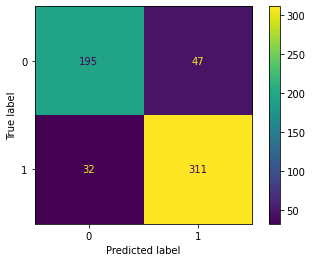

In [23]:
name = "Reliability"
df1 = df[(pd.isna(df[name]) != True)]
df1.index = range(df1.shape[0])
df1[name] = df1[name].astype('int64')

df1[name] = df1[name] .apply(lambda x : kn(x))
d1 = df1[df1[name]==1].sample(1344)
d2 = df1[df1[name]==0].sample(df1[df1[name]==0].shape[0])
df1 = pd.concat([d1,d2])
df1.index = range(df1.shape[0])

counter = CountVectorizer(max_df=0.8, min_df=4)
counts = counter.fit_transform(df1['clean_review'].values.tolist())
tfidfer = TfidfTransformer()
x = tfidfer.fit_transform(counts)
word=counter.get_feature_names()
y = df1[name]
X_train, X_test, y_train, y_test = train_test_split(x,y,random_state=1)
clf = SVC().fit(X_train, y_train)
print('svm：',clf.score(X_test, y_test))
pre = clf.predict(X_test)
print(classification_report(y_test,pre))
metrics.plot_confusion_matrix(clf, X_test, y_test)

### Value

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn

svm： 0.821656050955414
              precision    recall  f1-score   support

           0       0.82      0.67      0.74       237
           1       0.82      0.91      0.86       391

    accuracy                           0.82       628
   macro avg       0.82      0.79      0.80       628
weighted avg       0.82      0.82      0.82       628



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


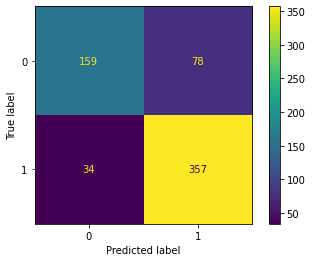

In [24]:
name = "Value"
df1 = df[(pd.isna(df[name]) != True)]
df1.index = range(df1.shape[0])
df1[name] = df1[name].astype('int64')

df1[name] = df1[name] .apply(lambda x : kn(x))
d1 = df1[df1[name]==1].sample(1549)
d2 = df1[df1[name]==0].sample(df1[df1[name]==0].shape[0])
df1 = pd.concat([d1,d2])
df1.index = range(df1.shape[0])

counter = CountVectorizer(max_df=0.8, min_df=4)
counts = counter.fit_transform(df1['clean_review'].values.tolist())
tfidfer = TfidfTransformer()
x = tfidfer.fit_transform(counts)
word=counter.get_feature_names()
y = df1[name]
X_train, X_test, y_train, y_test = train_test_split(x,y,random_state=1)
clf = SVC().fit(X_train, y_train)
print('svm：',clf.score(X_test, y_test))
pre = clf.predict(X_test)
print(classification_report(y_test,pre))
metrics.plot_confusion_matrix(clf, X_test, y_test)

## Bayes Improvement

### Safety

Bayes： 0.8167701863354038
              precision    recall  f1-score   support

           0       0.88      0.52      0.65       107
           1       0.80      0.96      0.88       215

    accuracy                           0.82       322
   macro avg       0.84      0.74      0.77       322
weighted avg       0.83      0.82      0.80       322



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.w

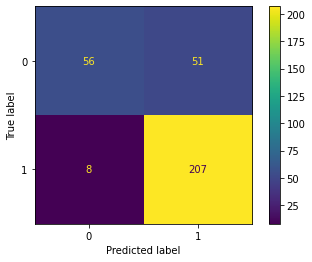

In [26]:
name = "Safety"
df1 = df[pd.isna(df[name]) != True]
df1.index = range(df1.shape[0])
df1[name] = df1[name].astype('int64')
df1[name] = df1[name] .apply(lambda x : kn(x))
d1 = df1[df1[name]==1].sample(883)
d2 = df1[df1[name]==0].sample(df1[df1[name]==0].shape[0])
df1 = pd.concat([d1,d2])
df1.index = range(df1.shape[0])
counter = CountVectorizer(max_df=0.8, min_df=4)
counts = counter.fit_transform(df1['clean_review'].values.tolist())
tfidfer = TfidfTransformer()
x = tfidfer.fit_transform(counts)
word = counter.get_feature_names()
y = df1[name]

X_train, X_test, y_train, y_test = train_test_split(x,y,random_state=1)

clf = MultinomialNB().fit(X_train, y_train)
print('Bayes：',clf.score(X_test, y_test))
pre = clf.predict(X_test)
print(classification_report(y_test,pre))
metrics.plot_confusion_matrix(clf, X_test, y_test)

### Technology

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Bayes： 0.7726432532347505
              precision    recall  f1-score   support

           0       0.80      0.37      0.51       170
           1       0.77      0.96      0.85       371

    accuracy                           0.77       541
   macro avg       0.78      0.66      0.68       541
weighted avg       0.78      0.77      0.74       541



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


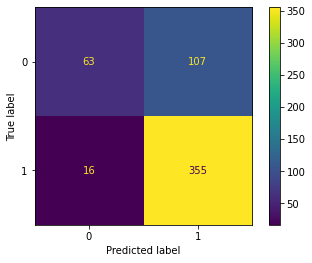

In [27]:
name = "Technology"
df1 = df[pd.isna(df[name]) != True]
df1.index = range(df1.shape[0])
df1[name] = df1[name].astype('int64')
df1[name] = df1[name] .apply(lambda x : kn(x))
d1 = df1[df1[name]==1].sample(1469)
d2 = df1[df1[name]==0].sample(df1[df1[name]==0].shape[0])
df1 = pd.concat([d1,d2])
df1.index = range(df1.shape[0])
counter = CountVectorizer(max_df=0.8, min_df=4)
counts = counter.fit_transform(df1['clean_review'].values.tolist())
tfidfer = TfidfTransformer()
x = tfidfer.fit_transform(counts)
word = counter.get_feature_names()
y = df1[name]

X_train, X_test, y_train, y_test = train_test_split(x,y,random_state=1)

clf = MultinomialNB().fit(X_train, y_train)
print('Bayes：',clf.score(X_test, y_test))
pre = clf.predict(X_test)
print(classification_report(y_test,pre))
metrics.plot_confusion_matrix(clf, X_test, y_test)

### Performance

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Bayes： 0.8042553191489362
              precision    recall  f1-score   support

           0       0.82      0.57      0.67       166
           1       0.80      0.93      0.86       304

    accuracy                           0.80       470
   macro avg       0.81      0.75      0.77       470
weighted avg       0.81      0.80      0.79       470



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


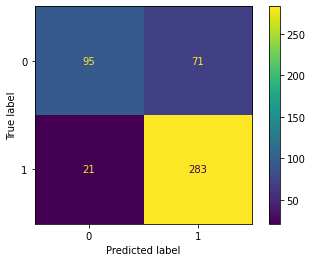

In [28]:
name = "Performance"
df1 = df[pd.isna(df[name]) != True]
df1.index = range(df1.shape[0])
df1[name] = df1[name].astype('int64')
df1[name] = df1[name] .apply(lambda x : kn(x))
d1 = df1[df1[name]==1].sample(1207)
d2 = df1[df1[name]==0].sample(df1[df1[name]==0].shape[0])
df1 = pd.concat([d1,d2])
df1.index = range(df1.shape[0])
counter = CountVectorizer(max_df=0.8, min_df=4)
counts = counter.fit_transform(df1['clean_review'].values.tolist())
tfidfer = TfidfTransformer()
x = tfidfer.fit_transform(counts)
word = counter.get_feature_names()
y = df1[name]

X_train, X_test, y_train, y_test = train_test_split(x,y,random_state=1)

clf = MultinomialNB().fit(X_train, y_train)
print('Bayes：',clf.score(X_test, y_test))
pre = clf.predict(X_test)
print(classification_report(y_test,pre))
metrics.plot_confusion_matrix(clf, X_test, y_test)

### Interior

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.w

svBayes： 0.7366946778711485
              precision    recall  f1-score   support

           0       1.00      0.10      0.18       104
           1       0.73      1.00      0.84       253

    accuracy                           0.74       357
   macro avg       0.86      0.55      0.51       357
weighted avg       0.81      0.74      0.65       357



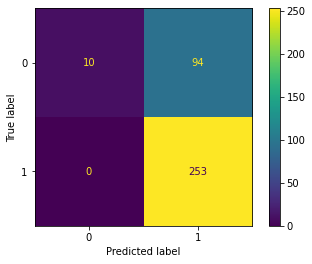

In [29]:
name = "Interior"
df1 = df[pd.isna(df[name]) != True]
df1.index = range(df1.shape[0])
df1[name] = df1[name].astype('int64')
df1[name] = df1[name] .apply(lambda x : kn(x))
d1 = df1[df1[name]==1].sample(1013)
d2 = df1[df1[name]==0].sample(df1[df1[name]==0].shape[0])
df1 = pd.concat([d1,d2])
df1.index = range(df1.shape[0])
counter = CountVectorizer(max_df=0.8, min_df=4)
counts = counter.fit_transform(df1['clean_review'].values.tolist())
tfidfer = TfidfTransformer()
x = tfidfer.fit_transform(counts)
word = counter.get_feature_names()
y = df1[name]

X_train, X_test, y_train, y_test = train_test_split(x,y,random_state=1)

clf = MultinomialNB().fit(X_train, y_train)
print('svBayes：',clf.score(X_test, y_test))
pre = clf.predict(X_test)
print(classification_report(y_test,pre))
metrics.plot_confusion_matrix(clf, X_test, y_test)

### Comfort

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.w

Bayes： 0.7432432432432432
              precision    recall  f1-score   support

           0       0.81      0.16      0.26       108
           1       0.74      0.98      0.84       262

    accuracy                           0.74       370
   macro avg       0.77      0.57      0.55       370
weighted avg       0.76      0.74      0.67       370



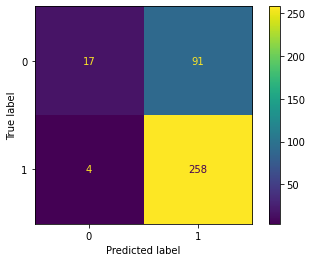

In [30]:
name = "Comfort"
df1 = df[pd.isna(df[name]) != True & (df[name]!='H')]
df1.index = range(df1.shape[0])
df1[name] = df1[name].astype('int64')
df1[name] = df1[name] .apply(lambda x : kn(x))
d1 = df1[df1[name]==1].sample(1040)
d2 = df1[df1[name]==0].sample(df1[df1[name]==0].shape[0])
df1 = pd.concat([d1,d2])
df1.index = range(df1.shape[0])
counter = CountVectorizer(max_df=0.8, min_df=4)
counts = counter.fit_transform(df1['clean_review'].values.tolist())
tfidfer = TfidfTransformer()
x = tfidfer.fit_transform(counts)
word = counter.get_feature_names()
y = df1[name]

X_train, X_test, y_train, y_test = train_test_split(x,y,random_state=1)

clf = MultinomialNB().fit(X_train, y_train)
print('Bayes：',clf.score(X_test, y_test))
pre = clf.predict(X_test)
print(classification_report(y_test,pre))
metrics.plot_confusion_matrix(clf, X_test, y_test)

### Reliability

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Bayes： 0.8512820512820513
              precision    recall  f1-score   support

           0       0.85      0.78      0.81       242
           1       0.85      0.90      0.88       343

    accuracy                           0.85       585
   macro avg       0.85      0.84      0.84       585
weighted avg       0.85      0.85      0.85       585



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


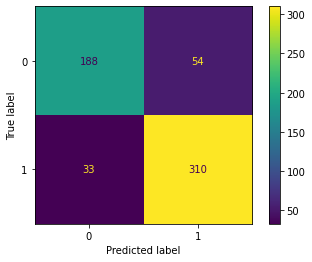

In [32]:
name = "Reliability"
df1 = df[pd.isna(df[name]) != True]
df1.index = range(df1.shape[0])
df1[name] = df1[name].astype('int64')
df1[name] = df1[name] .apply(lambda x : kn(x))
d1 = df1[df1[name]==1].sample(1344)
d2 = df1[df1[name]==0].sample(df1[df1[name]==0].shape[0])
df1 = pd.concat([d1,d2])
df1.index = range(df1.shape[0])
counter = CountVectorizer(max_df=0.8, min_df=4)
counts = counter.fit_transform(df1['clean_review'].values.tolist())
tfidfer = TfidfTransformer()
x = tfidfer.fit_transform(counts)
word = counter.get_feature_names()
y = df1[name]

X_train, X_test, y_train, y_test = train_test_split(x,y,random_state=1)

clf = MultinomialNB().fit(X_train, y_train)
print('Bayes：',clf.score(X_test, y_test))
pre = clf.predict(X_test)
print(classification_report(y_test,pre))
metrics.plot_confusion_matrix(clf, X_test, y_test)

### Value

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Bayes： 0.8105095541401274
              precision    recall  f1-score   support

           0       0.83      0.62      0.71       237
           1       0.80      0.92      0.86       391

    accuracy                           0.81       628
   macro avg       0.82      0.77      0.79       628
weighted avg       0.81      0.81      0.80       628



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


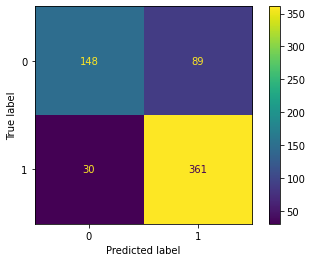

In [33]:
name = "Value"
df1 = df[pd.isna(df[name]) != True]
df1.index = range(df1.shape[0])
df1[name] = df1[name].astype('int64')
df1[name] = df1[name] .apply(lambda x : kn(x))
d1 = df1[df1[name]==1].sample(1549)
d2 = df1[df1[name]==0].sample(df1[df1[name]==0].shape[0])
df1 = pd.concat([d1,d2])
df1.index = range(df1.shape[0])
counter = CountVectorizer(max_df=0.8, min_df=4)
counts = counter.fit_transform(df1['clean_review'].values.tolist())
tfidfer = TfidfTransformer()
x = tfidfer.fit_transform(counts)
word = counter.get_feature_names()
y = df1[name]

X_train, X_test, y_train, y_test = train_test_split(x,y,random_state=1)

clf = MultinomialNB().fit(X_train, y_train)
print('Bayes：',clf.score(X_test, y_test))
pre = clf.predict(X_test)
print(classification_report(y_test,pre))
metrics.plot_confusion_matrix(clf, X_test, y_test)